In [1]:
import numpy as np

from statespace.models import NVMLangevinModel
from statespace.models import NVMConstantVelocityModel

from stochastic.processes import GammaProcess
from stochastic.processes import GeneralisedInverseGaussianProcess

from statespace.methods import KalmanFilter, MetropolisHastingsKalmanFilter

import pandas as pd
import matplotlib.pyplot as plt

# Langevin model example:

## Generate data:

In [2]:
T = np.linspace(0, 100, num=100).reshape(-1, 1)

In [3]:
# gamma_process_params = {"beta":1., "C":1.}
# subordinator = GammaProcess(**gamma_process_params)

In [4]:
gig_process_params = {"lam":-0.8, "gamma":0.01, "delta":1.0}
subordinator = GeneralisedInverseGaussianProcess(**gig_process_params)

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to improved version.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.


In [5]:
# # student t process:
# lam = -2.5
# delta = np.sqrt(-2 * lam)

# gig_process_params = {"lam":lam, "gamma":0, "delta":delta}
# subordinator = GeneralisedInverseGaussianProcess(**gig_process_params)

In [5]:
mu = 0.
theta = -0.2
sigma = 1.0
sigma_eps = 0.1

langevin_model = NVMLangevinModel(subordinator=subordinator, theta=theta, mu=mu, sigma=sigma, sigma_eps=sigma_eps, shape=(2,1))

In [6]:
x, y = langevin_model.sample(times=T)

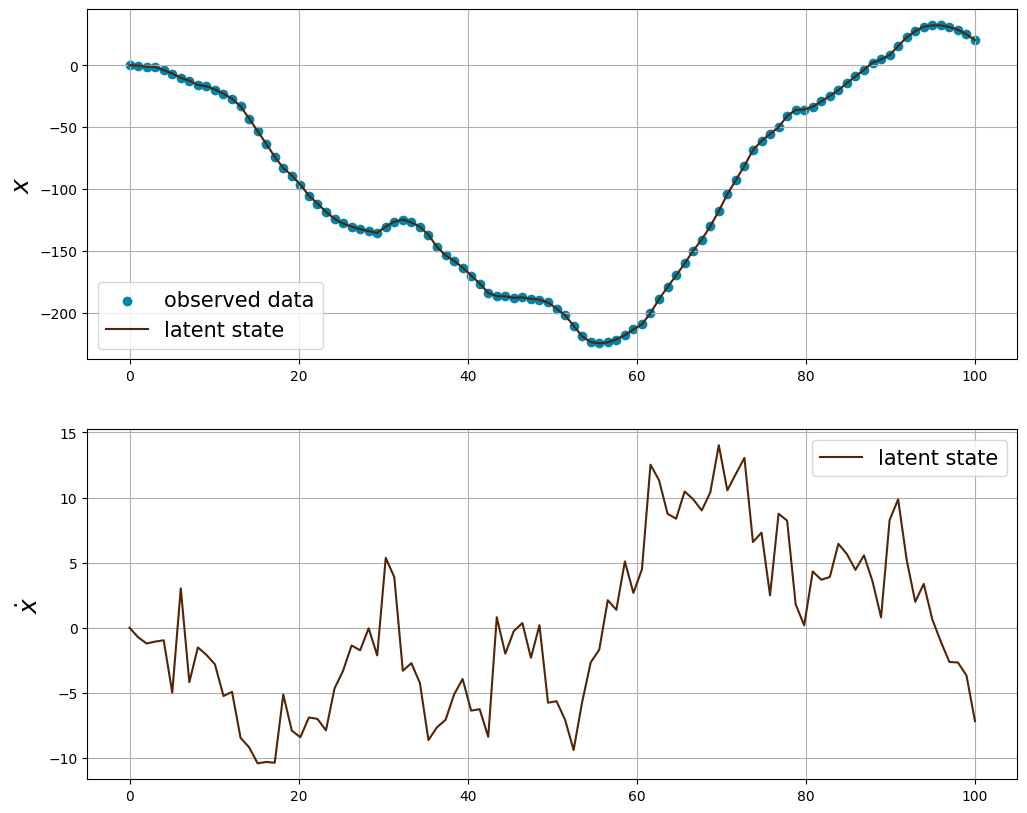

In [7]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

In [8]:
langevin_model.get_parameter_values()

{'theta': -0.2, 'mu': 0.0, 'sigma': 1.0, 'sigma_eps': 0.1}

## Kalman filtering with true subordinator jumps:

In [9]:
inference_method = KalmanFilter(model=langevin_model, prior=None, proposal=None)

The prior configuration is not valid.


In [10]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.1, size=(x[0].shape[0], 1))

P_init = np.random.normal(loc=0., scale=1., size=(x[0].shape[0], x[0].shape[0]))
P_init = np.matmul(P_init.T, P_init)

In [11]:
history = inference_method.filter(times=T, y=y, x_init=x_init, P_init=P_init)

In [12]:
x_est = inference_method.x_est
P_est = inference_method.P_est

vars = np.array([np.diag(COV) for COV in P_est[1:,:,:]])

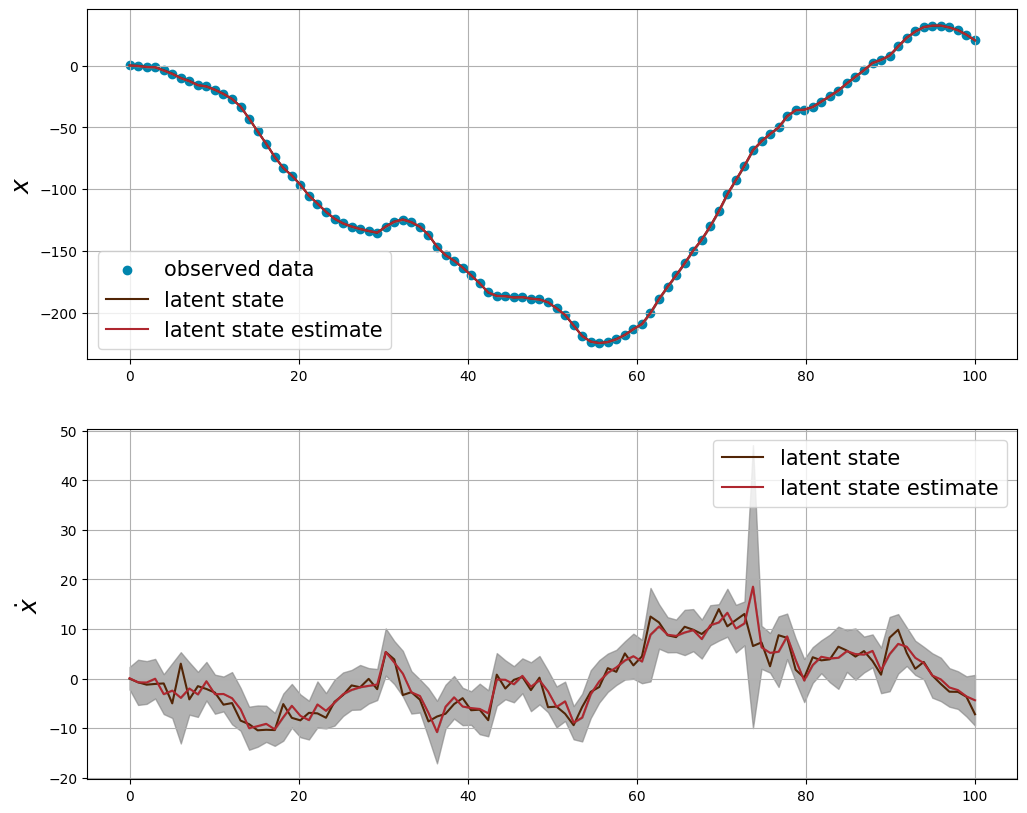

In [13]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")

# Plot state estimate:
ax[0].plot(T, x_est[1:,0,:], color="#AF272F", label="latent state estimate")
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() + 3 * np.sqrt(vars[:, 0]), color='grey', alpha=0.6)
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() - 3 * np.sqrt(vars[:, 0]), color='grey', alpha=0.6)

# Settings:
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")

# Plot velocity state estimate:
ax[1].plot(T, x_est[1:,1,:], color="#AF272F", label="latent state estimate")
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() + 3 * np.sqrt(vars[:, 1]), color='grey', alpha=0.6)
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() - 3 * np.sqrt(vars[:, 1]), color='grey', alpha=0.6)

# Settings:
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

## Sequential Marginalised Metropolis-Hastings Filter:

In [14]:
subordinator_inference = GeneralisedInverseGaussianProcess(**gig_process_params)
# subordinator_inference = GammaProcess(**gamma_process_params)

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to improved version.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.


In [15]:
langevin_model_inference = NVMLangevinModel(subordinator=subordinator_inference, theta=theta, mu=mu, sigma=sigma, sigma_eps=sigma_eps, shape=(2,1))

In [16]:
inference_method_inference = MetropolisHastingsKalmanFilter(model=langevin_model_inference, prior=None, proposal=None)

The prior configuration is not valid.


In [17]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.1, size=(x[0].shape[0], 1))

P_init = np.random.normal(loc=0., scale=1., size=(x[0].shape[0], x[0].shape[0]))
P_init = np.matmul(P_init.T, P_init)

In [18]:
history = inference_method_inference.filter(times=T, y=y, x_init=x_init, P_init=P_init, n_samples=100)

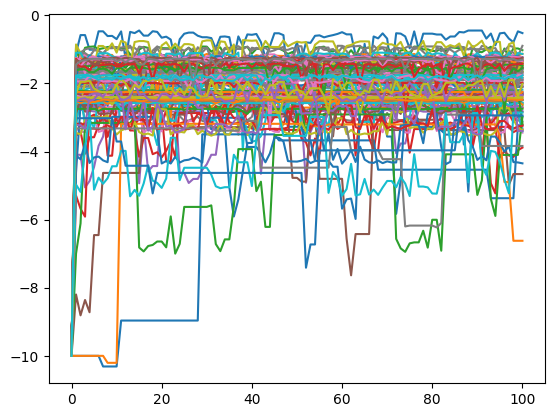

In [22]:
# Log marginal likelihood for each individual iteration

fig, ax = plt.subplots()

ax.plot(np.array(inference_method_inference.log_evidence)[:,:,0,0].T)

plt.show()

In [23]:
post_means = inference_method_inference.x_est[1:]
post_vars = np.array([np.diag(COV) for COV in inference_method_inference.P_est[1:]])

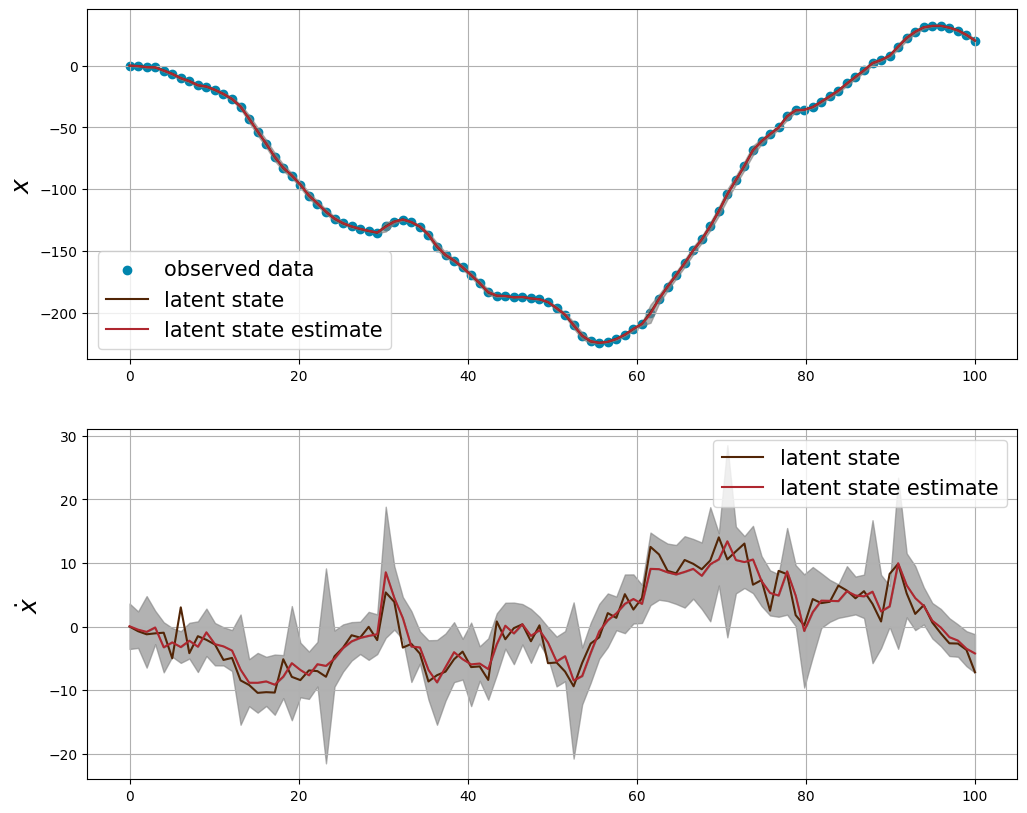

In [25]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")

# Plot state estimate:
ax[0].plot(T, post_means[:,0,:], color="#AF272F", label="latent state estimate")
ax[0].fill_between(T.flatten(), post_means[:,0,:].flatten(), post_means[:,0,:].flatten() + 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.6)
ax[0].fill_between(T.flatten(), post_means[:,0,:].flatten(), post_means[:,0,:].flatten() - 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.6)

#ax[0].set_ybound(-0.05, 0.25)

# Settings:
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")

# Plot velocity state estimate:
ax[1].plot(T, post_means[:,1,:], color="#AF272F", label="latent state estimate")
ax[1].fill_between(T.flatten(), post_means[:,1,:].flatten(), post_means[:,1,:].flatten() + 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)
ax[1].fill_between(T.flatten(), post_means[:,1,:].flatten(), post_means[:,1,:].flatten() - 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)

#ax[1].set_ybound(-0.25, 0.25)

# Settings:
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

# Constant velocity model:

## Generate data:

In [26]:
T = np.linspace(0, 10, num=100).reshape(-1, 1)

In [27]:
# student t process:
lam = -2.5
delta = np.sqrt(-2 * lam)

gig_process_params = {"lam":lam, "gamma":0, "delta":delta}
subordinator = GeneralisedInverseGaussianProcess(**gig_process_params)

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to GIG paper version.
The dominating point process is set as a stable process.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.


In [28]:
constant_velocity_model = NVMConstantVelocityModel(subordinator=subordinator, mu=0., sigma=1., sigma_eps=0.1, shape=(2,1))

In [29]:
x, y = constant_velocity_model.sample(times=T)

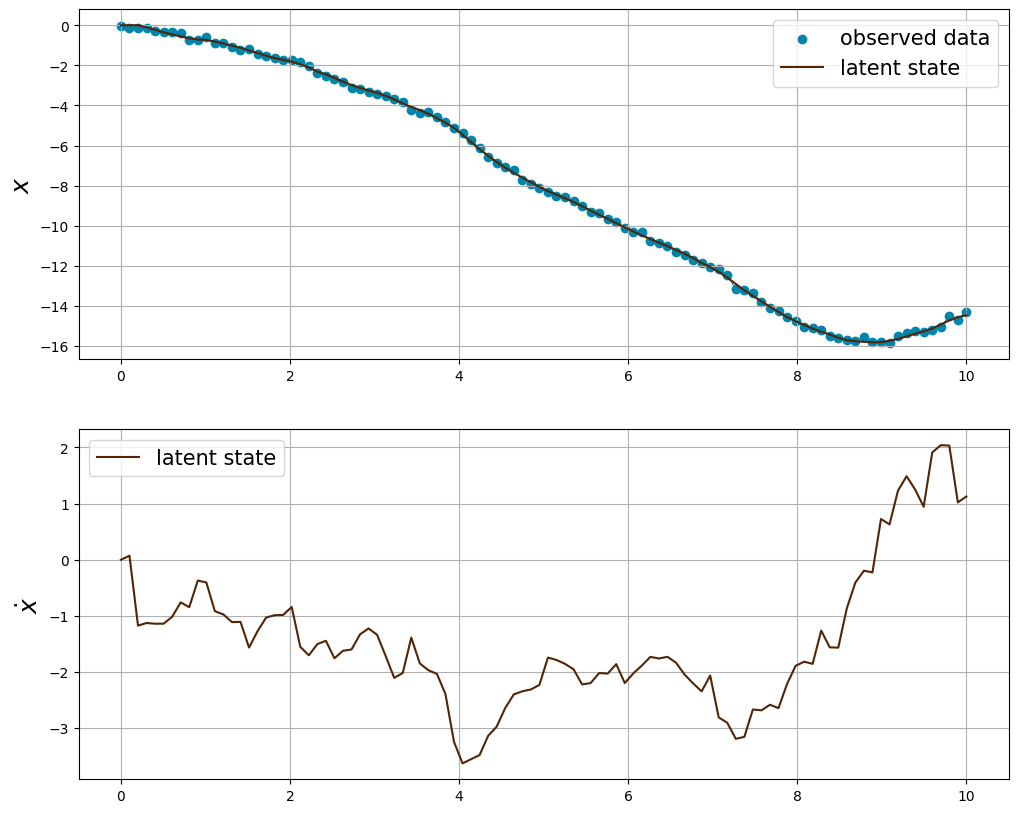

In [30]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

In [31]:
constant_velocity_model.get_parameter_values()

{'mu': 0.0, 'sigma': 1.0, 'sigma_eps': 0.1}

## Kalman filtering with true subordinator jumps:

In [32]:
inference_method = KalmanFilter(model=constant_velocity_model, prior=None, proposal=None)

The prior configuration is not valid.


In [33]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.1, size=(x[0].shape[0], 1))

P_init = np.random.normal(loc=0., scale=1., size=(x[0].shape[0], x[0].shape[0]))
P_init = np.matmul(P_init.T, P_init)

In [34]:
history = inference_method.filter(times=T, y=y, x_init=x_init, P_init=P_init)

In [35]:
x_est = inference_method.x_est
P_est = inference_method.P_est

vars = np.array([np.diag(COV) for COV in P_est[1:,:,:]])

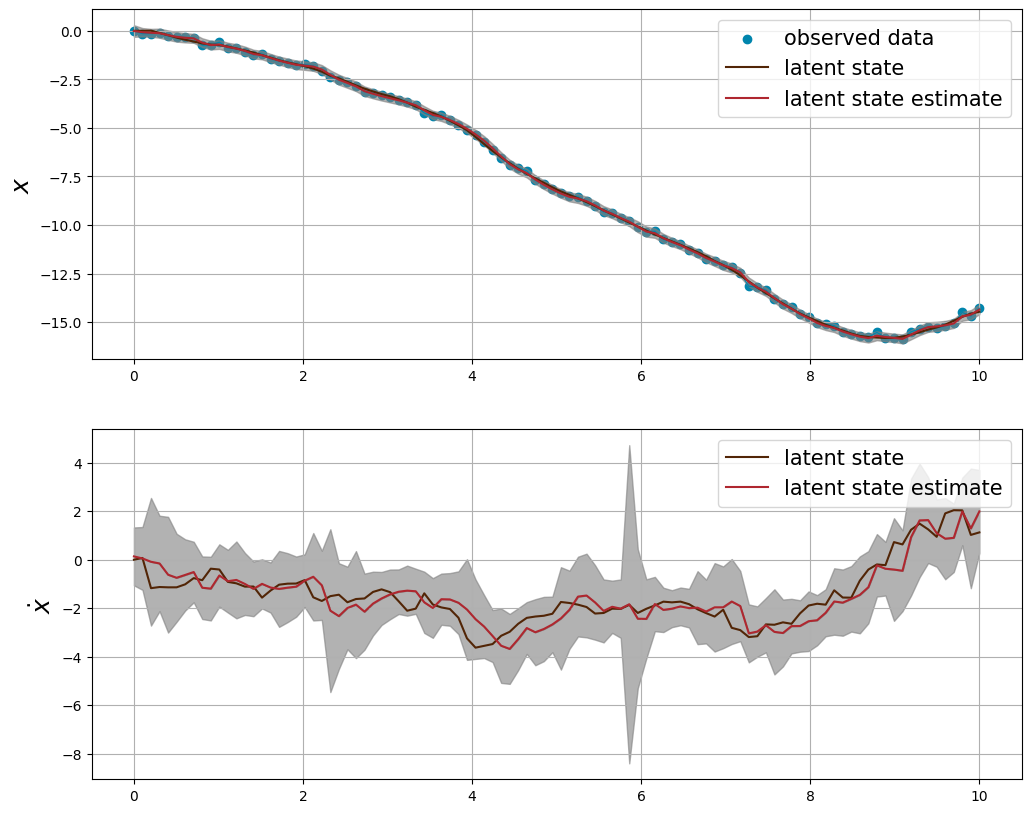

In [36]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")

# Plot state estimate:
ax[0].plot(T, x_est[1:,0,:], color="#AF272F", label="latent state estimate")
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() + 3 * np.sqrt(vars[:, 0]), color='grey', alpha=0.6)
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() - 3 * np.sqrt(vars[:, 0]), color='grey', alpha=0.6)

# Settings:
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")

# Plot velocity state estimate:
ax[1].plot(T, x_est[1:,1,:], color="#AF272F", label="latent state estimate")
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() + 3 * np.sqrt(vars[:, 1]), color='grey', alpha=0.6)
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() - 3 * np.sqrt(vars[:, 1]), color='grey', alpha=0.6)

# Settings:
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

## Sequential Marginalised Metropolis-Hastings Filter:

In [37]:
subordinator_inference = GeneralisedInverseGaussianProcess(**gig_process_params)
# subordinator_inference = GammaProcess(**gamma_process_params)

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to GIG paper version.
The dominating point process is set as a stable process.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.


In [38]:
constant_velocity_model_inference = NVMConstantVelocityModel(subordinator=subordinator_inference, mu=0., sigma=1., sigma_eps=0.1, shape=(2,1))

In [39]:
inference_method_inference = MetropolisHastingsKalmanFilter(model=constant_velocity_model_inference, prior=None, proposal=None)

The prior configuration is not valid.


In [40]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.1, size=(x[0].shape[0], 1))

P_init = np.random.normal(loc=0., scale=1., size=(x[0].shape[0], x[0].shape[0]))
P_init = np.matmul(P_init.T, P_init)

In [41]:
history = inference_method_inference.filter(times=T, y=y, x_init=x_init, P_init=P_init, n_samples=100)

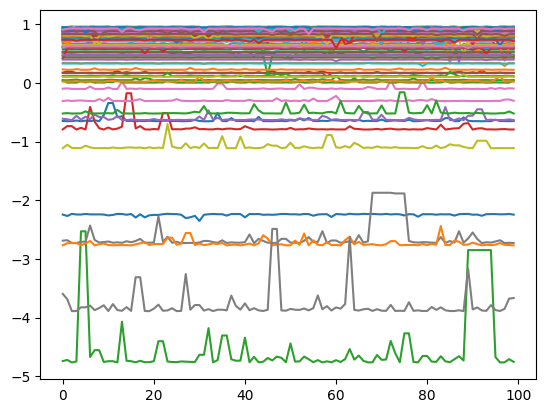

In [42]:
# Log marginal likelihood for each individual iteration

fig, ax = plt.subplots()

ax.plot(np.array(inference_method_inference.log_evidence)[:,1:,0,0].T)

plt.show()

In [43]:
post_means = inference_method_inference.x_est[1:]
post_vars = np.array([np.diag(COV) for COV in inference_method_inference.P_est[1:]])

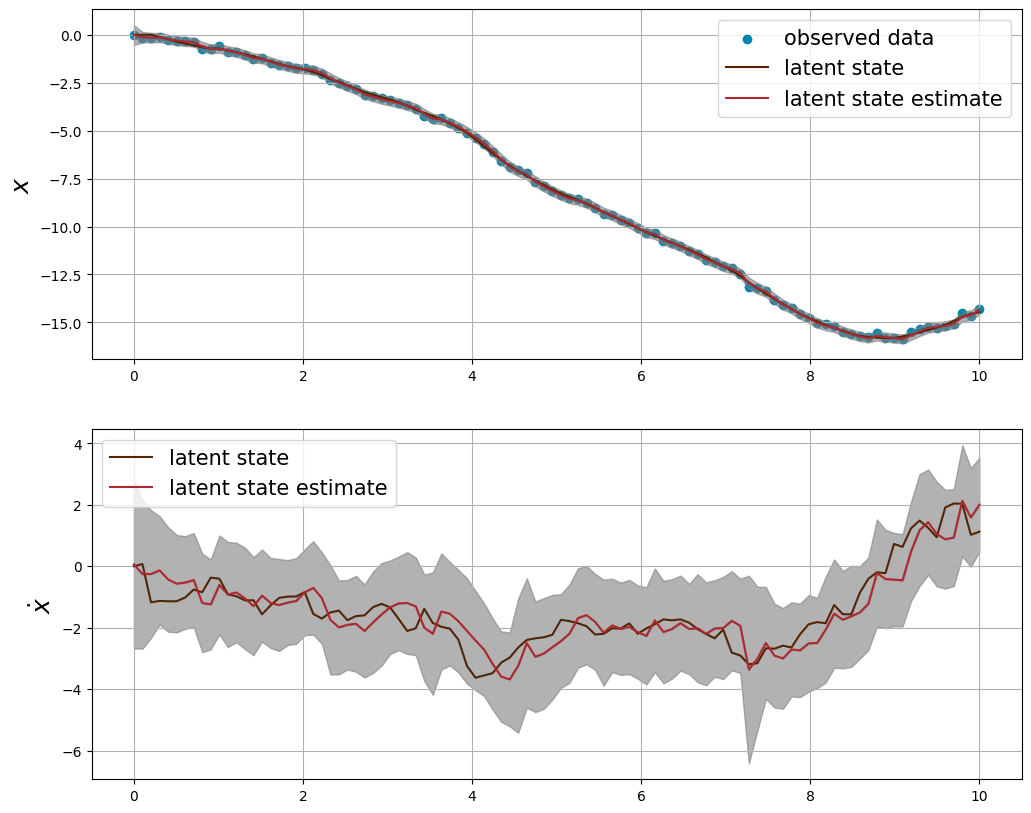

In [44]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")

# Plot state estimate:
ax[0].plot(T, post_means[:,0,:], color="#AF272F", label="latent state estimate")
ax[0].fill_between(T.flatten(), post_means[:,0,:].flatten(), post_means[:,0,:].flatten() + 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.6)
ax[0].fill_between(T.flatten(), post_means[:,0,:].flatten(), post_means[:,0,:].flatten() - 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.6)

#ax[0].set_ybound(-0.05, 0.25)

# Settings:
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")

# Plot velocity state estimate:
ax[1].plot(T, post_means[:,1,:], color="#AF272F", label="latent state estimate")
ax[1].fill_between(T.flatten(), post_means[:,1,:].flatten(), post_means[:,1,:].flatten() + 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)
ax[1].fill_between(T.flatten(), post_means[:,1,:].flatten(), post_means[:,1,:].flatten() - 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)

#ax[1].set_ybound(-0.25, 0.25)

# Settings:
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()